In [1]:
import pandas as pd
from fastai import *
from fastai.vision import *
from sklearn.preprocessing import OneHotEncoder
from ranger import Ranger
from radam import *

### Ideas
1.) Weighted Focal Loss - Done <br>
2.) Are vowels and consonants correlated to root; if so then post process <br>
3.) Softmax networks on predictions of multilabel <br>
4.) RADAM optimizer

In [2]:
'''import numpy as np
import sklearn.metrics

scores = []
for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
    y_true_subset = solution[solution[component] == component]['target'].values
    y_pred_subset = submission[submission[component] == component]['target'].values
    scores.append(sklearn.metrics.recall_score(
        y_true_subset, y_pred_subset, average='macro'))
final_score = np.average(scores, weights=[2,1,1])'''

"import numpy as np\nimport sklearn.metrics\n\nscores = []\nfor component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:\n    y_true_subset = solution[solution[component] == component]['target'].values\n    y_pred_subset = submission[submission[component] == component]['target'].values\n    scores.append(sklearn.metrics.recall_score(\n        y_true_subset, y_pred_subset, average='macro'))\nfinal_score = np.average(scores, weights=[2,1,1])"

In [3]:
training_labels = pd.read_csv('./train.csv')
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200840 entries, 0 to 200839
Data columns (total 5 columns):
image_id               200840 non-null object
grapheme_root          200840 non-null int64
vowel_diacritic        200840 non-null int64
consonant_diacritic    200840 non-null int64
grapheme               200840 non-null object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


In [4]:
enc_grapheme_root = OneHotEncoder()
enc_grapheme_root.fit(training_labels.grapheme_root.values.reshape(-1,1))
labels_grapheme = enc_grapheme_root.transform(training_labels.grapheme_root.values.reshape(-1,1))
labels_grapheme = pd.DataFrame(labels_grapheme.toarray(), 
                               columns=['grapheme_' + str(i) 
                                        for i in range(labels_grapheme.shape[1])])
labels_grapheme.shape

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(200840, 168)

In [5]:
enc_vowel_diacritic = OneHotEncoder()
enc_vowel_diacritic.fit(training_labels.vowel_diacritic.values.reshape(-1,1))
labels_vowel = enc_vowel_diacritic.transform(training_labels.vowel_diacritic.values.reshape(-1,1))
labels_vowel = pd.DataFrame(labels_vowel.toarray(), 
                            columns = ['vowel_' + str(i) 
                                       for i in range(labels_vowel.shape[1])])
labels_vowel.shape

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(200840, 11)

In [6]:
enc_consonant_diacritic = OneHotEncoder()
enc_consonant_diacritic.fit(training_labels.consonant_diacritic.values.reshape(-1,1))
labels_consonent = enc_consonant_diacritic.transform(training_labels.consonant_diacritic.values.reshape(-1,1))
labels_consonent = pd.DataFrame(labels_consonent.toarray(), 
                                columns = ['consonant_'+str(i) 
                                           for i in range(labels_consonent.shape[1])])
labels_consonent.shape

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\sklearn\preprocessing\_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(200840, 7)

In [7]:
df_train = training_labels[['image_id']]
df_train['image_id'] = df_train['image_id']+'.jpg'
df_train = pd.concat([df_train, labels_grapheme, labels_vowel, labels_consonent], 
                     axis = 1)
df_train.shape

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(200840, 187)

In [8]:
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [9]:
from torch import nn
import torch.nn.functional as F

class FocalLoss_wtd(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduction='elementwise_mean'):
        super(FocalLoss_wtd, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = 2 * F.binary_cross_entropy_with_logits(inputs[:,0:168], targets[:,0:168], 
                                                            reduction='none') \
            + 1 * F.binary_cross_entropy_with_logits(inputs[:,168:179], targets[:,168:179], 
                                                            reduction='none') \
            + 1 * F.binary_cross_entropy_with_logits(inputs[:,179:186], targets[:,179:186], 
                                                            reduction='none')
        else:
            BCE_loss = 2 * F.binary_cross_entropy(inputs[:,0:168], targets[:,0:168], 
                                                  reduction='none') \
            + 1 * F.binary_cross_entropy(inputs[:,168:179], targets[:,168:179], 
                                                  reduction='none') \
            + 1 * F.binary_cross_entropy(inputs[:,179:186], targets[:,179:186], 
                                                  reduction='none') 
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction is None:
            return F_loss
        else:
            return torch.mean(F_loss)

In [10]:
df_train.head()

,image_id,grapheme_0,grapheme_1,grapheme_2,grapheme_3,grapheme_4,grapheme_5,grapheme_6,grapheme_7,grapheme_8,...,vowel_8,vowel_9,vowel_10,consonant_0,consonant_1,consonant_2,consonant_3,consonant_4,consonant_5,consonant_6
0,Train_0.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Train_1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Train_2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Train_3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Train_4.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
np.random.seed(42)

In [12]:
tfms = get_transforms(max_zoom=1.3, 
                      max_rotate=25, 
                      max_warp=0.2, 
                      p_affine=0.2)
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-25, 25)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.2, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=Tr

In [13]:
size = 128
src = ImageImageList.from_df(df_train, path='./', folder='train_images')\
.split_by_rand_pct(0.2)\
.label_from_df(cols=df_train.columns[1:].tolist(), label_cls=MultiCategoryList, one_hot=True)\
.transform(tfms,size=size)\
.databunch(bs=16)\
.normalize()
src#.show_batch(rows=2, figsize=(6,6))

ImageDataBunch;

Train: LabelList (160672 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
grapheme_15;vowel_9;consonant_5,grapheme_159;vowel_0;consonant_0,grapheme_22;vowel_3;consonant_5,grapheme_53;vowel_2;consonant_2,grapheme_153;vowel_9;consonant_0
Path: .;

Valid: LabelList (40168 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
grapheme_151;vowel_5;consonant_0,grapheme_23;vowel_7;consonant_2,grapheme_81;vowel_1;consonant_4,grapheme_107;vowel_8;consonant_0,grapheme_32;vowel_7;consonant_0
Path: .;

Test: None

In [14]:
# optar = partial(Ranger)
# optar = partial(RAdam)

In [15]:
class CutMixCallback(LearnerCallback):
    def __init__(self, learn:Learner, probability=0.1):
      super().__init__(learn)
      self.probability = probability
      assert probability > 0 and probability <= 1

    def on_train_begin(self, **kwargs):
      return
      if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
      if not train: return

      examples_count, channels_count, height, width = last_input.size()
      dest_example_idx, src_example_idx = torch.randperm(examples_count)[:2]
      λ = torch.rand(tuple())
      start_col = torch.randint(width, tuple())
      start_row = torch.randint(height, tuple())
      region_w = width * torch.sqrt(1 - λ)
      region_h = height * torch.sqrt(1 - λ)
      end_col = start_col + region_w.int()
      end_row = start_row + region_h.int()

      last_input[dest_example_idx,:,start_row:end_row,start_col:end_col] = last_input[src_example_idx,:,start_row:end_row,start_col:end_col]
      last_target[dest_example_idx] = last_target[dest_example_idx]*λ + last_target[src_example_idx]*(1-λ)
      # Note to self: images will show up nicely in Files tab <3. This blows up number of iterations 
      #wandb.log({"cutmix": [wandb.Image(last_input[dest_example_idx], caption="Label")]})
      return {'last_input': last_input, 'last_target': last_target}  
    
    def on_train_end(self, **kwargs):
        return
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()

In [16]:
accuracy = partial(accuracy_thresh, thresh=0.2)
f1_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(src,models.resnet50,metrics=[accuracy, f1_score], 
                    # opt_func=optar
                   )
# learn = cnn_learner(src,models.densenet201,metrics=[accuracy, f1_score])
# learn.loss_fn = FocalLoss()
learn.loss_fn = FocalLoss_wtd()
# learn.opt_fun = optar

In [17]:
learn.data.stats

[tensor([0.9399, 0.9399, 0.9399]), tensor([0.1699, 0.1699, 0.1699])]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 3.63E-02


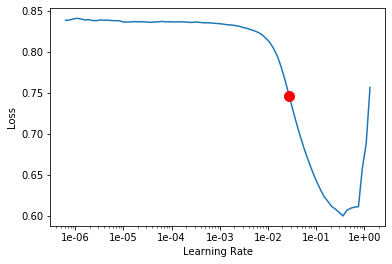

In [18]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [19]:
min_grad_lr = learn.recorder.min_grad_lr
min_grad_lr

0.027542287033381692

In [20]:
learn.fit_one_cycle(60,slice(1e-3), callbacks=[CutMixCallback(learn)])
# learn.fit_one_cycle(40,min_grad_lr)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.050921,0.046552,0.984529,0.503975,24:39
1,0.046398,0.040869,0.985571,0.557018,22:30
2,0.042031,0.036248,0.986852,0.599163,22:31
3,0.038300,0.032216,0.988070,0.639230,22:36
4,0.036365,0.028641,0.989252,0.678494,22:36
5,0.033272,0.025493,0.990435,0.716641,22:30
6,0.031290,0.022693,0.991217,0.753801,22:29
7,0.030296,0.020541,0.992308,0.777820,22:32
8,0.028194,0.018821,0.992850,0.802052,22:35
9,0.026488,0.017079,0.993276,0.826457,22:48


In [ ]:
learn.fit_one_cycle(30,slice(1e-3))

In [ ]:
learn.fit_one_cycle(30,slice(1e-3))

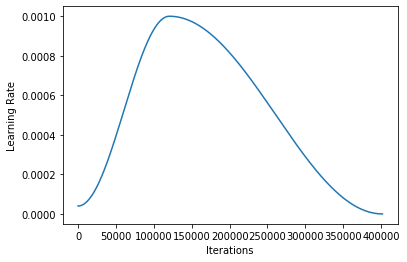

In [19]:
learn.recorder.plot_lr()

c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\users\y2ee2\anaconda3\envs\devenv\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


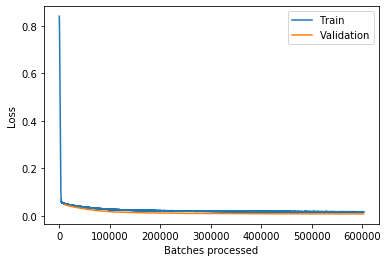

In [21]:
learn.recorder.plot_losses()

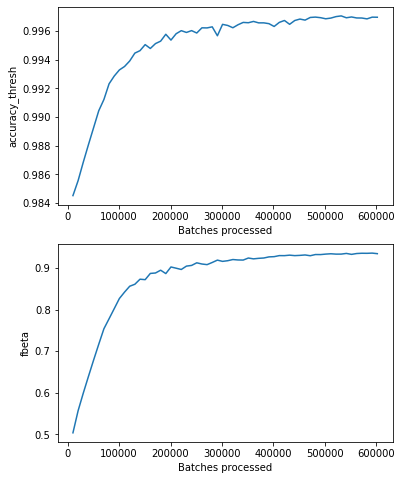

In [22]:
learn.recorder.plot_metrics()

In [27]:
# learn.save(Path('./saved_models'))
# learn.export('fastai_resnet')
learn.export('fastai_resnet_fl_wtd_filter_v4')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.29E-07


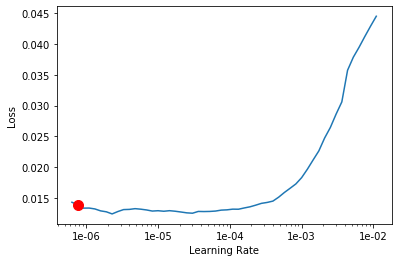

In [24]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [26]:
learn.fit_one_cycle(60,1e-6)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.012917,0.007601,0.996974,0.934420,33:23
1,0.012088,0.007500,0.996882,0.935881,33:13
2,0.012577,0.007387,0.997006,0.936433,34:12
3,0.012200,0.007347,0.996951,0.937250,33:43
4,0.012301,0.007312,0.996974,0.937079,33:38
5,0.012271,0.007205,0.997103,0.938080,33:35
6,0.011857,0.007057,0.997176,0.939223,33:33
7,0.012022,0.007067,0.997041,0.939825,34:13
8,0.011904,0.006876,0.997249,0.941030,34:15
9,0.011305,0.006738,0.997261,0.942201,33:44


In [30]:
learn.fit_one_cycle(60,1e-7)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.007237,0.004351,0.998337,0.962798,49:07
1,0.006458,0.004337,0.998253,0.963142,42:55
2,0.006856,0.004333,0.998252,0.963255,39:34
3,0.006758,0.004329,0.998256,0.963102,37:18
4,0.007081,0.004303,0.998231,0.963725,43:47
5,0.006945,0.004316,0.998254,0.963130,44:06
6,0.007009,0.004310,0.998335,0.963153,37:54
7,0.007179,0.004320,0.998292,0.963192,34:35
8,0.007061,0.004368,0.998304,0.962922,42:00
9,0.007107,0.004283,0.998310,0.963669,42:17


KeyboardInterrupt: 

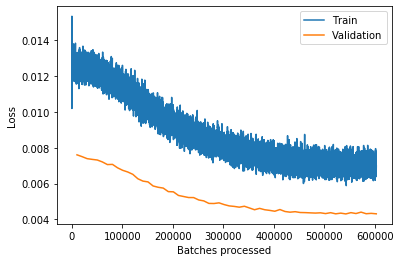

In [28]:
learn.recorder.plot_losses()

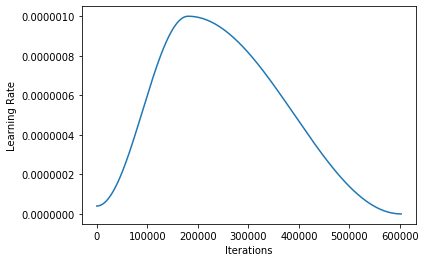

In [29]:
learn.recorder.plot_lr()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.export('fastai_resnet_fl_wtd_cropped')

In [ ]:
val_preds,val_targets = learn.get_preds()
val_preds.shape,val_targets.shape

In [ ]:
'''val_preds = pd.DataFrame(val_preds, columns=['feat'+str(i) for i in range(val_preds.shape[1])])
val_preds.info()
val_targets = pd.DataFrame(val_targets, columns=['target'+str(i) for i in range(val_preds.shape[1])])
val_targets.info()'''

In [ ]:
val_preds, val_targets = val_preds.numpy(), val_targets.numpy()
val_preds.shape,val_targets.shape

In [ ]:
from keras.models import Sequential
from keras.metrics import categorical_accuracy
from keras.layers import Dense, Softmax, Dropout

In [ ]:
nn_root = Sequential()
nn_root.add(Dense(val_preds.shape[1], activation='relu'))
nn_root.add(Dense(128, activation='relu'))
nn_root.add(Dense(64, activation='relu'))
nn_root.add(Dense(168, activation='softmax'))


nn_root.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=[categorical_accuracy])

train_history_root = nn_root.fit(val_preds[:,0:168], val_targets[:,0:168], epochs=10, batch_size=32, validation_split=0.2)
# nn_grapheme.summary()

In [ ]:
plt.plot(train_history_root.history['loss'])
plt.plot(train_history_root.history['val_loss'])

In [ ]:
plt.plot(train_history_root.history['categorical_accuracy'])
plt.plot(train_history_root.history['val_categorical_accuracy'])

In [ ]:
nn_vowel = Sequential()
nn_vowel.add(Dense(val_preds.shape[1], activation='relu'))
nn_vowel.add(Dense(128, activation='relu'))
nn_vowel.add(Dense(64, activation='relu'))
nn_vowel.add(Dense(11, activation='softmax'))

nn_vowel.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=[categorical_accuracy])

train_history_vowel = nn_vowel.fit(val_preds[:,168:179], val_targets[:,168:179], 
                                   epochs=10, batch_size=16, validation_split=0.2)
# nn_grapheme.summary()

In [ ]:
plt.plot(train_history_vowel.history['loss'])
plt.plot(train_history_vowel.history['val_loss'])

In [ ]:
plt.plot(train_history_vowel.history['categorical_accuracy'])
plt.plot(train_history_vowel.history['val_categorical_accuracy'])

In [ ]:
nn_consonant = Sequential()
nn_consonant.add(Dense(val_preds.shape[1], activation='relu'))
nn_consonant.add(Dense(128, activation='relu'))
nn_consonant.add(Dense(64, activation='relu'))
nn_consonant.add(Dense(7, activation='softmax'))

nn_consonant.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=[categorical_accuracy])

train_history_consonent = nn_consonant.fit(val_preds, val_targets[:,179:186], 
                                   epochs=10, batch_size=16, validation_split=0.2)
# nn_grapheme.summary()

In [ ]:
plt.plot(train_history_consonent.history['loss'])
plt.plot(train_history_consonent.history['val_loss'])

In [ ]:
plt.plot(train_history_consonent.history['categorical_accuracy'])
plt.plot(train_history_consonent.history['val_categorical_accuracy'])

In [ ]:
learn.opt_func